In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random

import torch
import torch.nn as nn

from utils import *
from dataloaders import pmnist
from approaches import ewc, si, ucl, vcl, hat
from networks import mlp_ucl, mlp, mlp_hat

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(42)

f:\anacoda3\envs\cl\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
f:\anacoda3\envs\cl\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
split = False  # Single-head
notMNIST = False

# Load data
print('Load data...')
data, taskcla, inputsize = pmnist.get(tasknum=10)
print('Input size =', inputsize, '\nTask info =', taskcla)

Load data...
0,1,2,3,4,5,6,7,8,9,Input size = [1, 28, 28] 
Task info = [(0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10)]


## 1. UCL

In [3]:
ucl_args = {
    'experiment': 'pmnist',
    'approach': 'ucl',
    'beta': 0.03,  # See the paper for more details
    'ratio': 0.5,
    'alpha': 0.01, # Initialized alpha, when a model is saved then alpha is set to 1,
    'seed': 42,
    'lr': 1e-3,
    'units': 400,
    'batch_size': 256,
    'epochs': 100,
    'optimizer': 'adam',
    'tasknum': 10,
    'parameter': '',
    'conv_net': False
}

log_name = '{}_{}_{}_alpha_{}_beta_{:.5f}_ratio_{:.4f}_lr_{}_units_{}_batch_{}_epoch_{}'.format(
        ucl_args['experiment'], ucl_args['approach'], ucl_args['seed'], ucl_args['alpha'], ucl_args['beta'], ucl_args['ratio'], 
        ucl_args['lr'], ucl_args['units'], ucl_args['batch_size'], ucl_args['epochs'])

ucl_args['output'] = './result_data/' + log_name + '.txt'

In [4]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

net = mlp_ucl.Net(inputsize, taskcla, ucl_args['ratio'], ucl_args['units'], split, notMNIST).cuda()
approach = ucl.Approach(net, 
                        ucl_args['epochs'],
                        ucl_args['batch_size'],
                        ucl_args['lr'],
                        args=ucl_args,
                        log_name=log_name,
                        split=split)

print_model_report(net)
print_optimizer_config(approach.optimizer)

----------------------------------------------------------------------------------------------------
Net(
  (fc1): BayesianLinear()
  (fc2): BayesianLinear()
  (last): BayesianLinear()
)
Dimensions = torch.Size([400, 784]) torch.Size([400]) torch.Size([400, 1]) torch.Size([400, 400]) torch.Size([400]) torch.Size([400, 1]) torch.Size([10, 400]) torch.Size([10]) torch.Size([10, 1]) 
Num parameters = 479.2K
----------------------------------------------------------------------------------------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
) = lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0, amsgrad: False, maximize: False, foreach: None, capturable: False, differentiable: False, fused: None, 


In [5]:
acc = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)
loss = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)

for t, ncla in taskcla:
    if t == ucl_args['tasknum']:
        break

    print('*' * 100)
    print('Task {:2d} ({:s})'.format(t, data[t]['name']))
    print('*' * 100)

    # Load data
    X_train = data[t]['train']['X'].cuda()
    y_train = data[t]['train']['y'].cuda()
    X_valid = data[t]['valid']['X'].cuda()
    y_valid = data[t]['valid']['y'].cuda()
    task = t

    # Train
    approach.train(task, X_train, y_train, X_valid, y_valid, data)
    print('-' * 100)

    # Test
    for u in range(t + 1):
        X_test = data[u]['test']['X'].cuda()
        y_test = data[u]['test']['y'].cuda()
        test_loss, test_acc = approach.eval(u, X_test, y_test)
        print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, data[u]['name'], test_loss,
                                                                                      100 * test_acc))
        acc[t, u] = test_acc
        loss[t, u] = test_loss

    # Save
    print('Save at ' + ucl_args['output'])
    np.savetxt(ucl_args['output'], acc, fmt='%.4f')
    torch.save(net.state_dict(), './models/trained_model/'+ log_name + '_task_{}.pt'.format(t))

# Done
print('*' * 100)
print('Accuracies =')
for i in range(acc.shape[0]):
    print('\t', end='')
    for j in range(acc.shape[1]):
        print('{:5.1f}% '.format(100 * acc[i, j]), end='')
    print()
print('*' * 100)
print('Done!')



****************************************************************************************************
Task  0 (pmnist-0)
****************************************************************************************************
| Epoch   1, time= 44.2ms/  0.9ms | | Train: loss=0.228, acc=  0.9 | Valid: loss=0.228, acc=  0.9 | *
| Epoch   2, time= 21.8ms/  0.8ms | | Train: loss=0.124, acc=  1.0 | Valid: loss=0.124, acc=  1.0 | *
| Epoch   3, time= 20.5ms/  0.8ms | | Train: loss=0.093, acc=  1.0 | Valid: loss=0.093, acc=  1.0 | *
| Epoch   4, time= 19.9ms/  0.7ms | | Train: loss=0.066, acc=  1.0 | Valid: loss=0.066, acc=  1.0 | *
| Epoch   5, time= 19.0ms/  0.7ms | | Train: loss=0.053, acc=  1.0 | Valid: loss=0.053, acc=  1.0 | *
| Epoch   6, time= 17.8ms/  0.8ms | | Train: loss=0.044, acc=  1.0 | Valid: loss=0.044, acc=  1.0 | *
| Epoch   7, time= 19.5ms/  0.9ms | | Train: loss=0.043, acc=  1.0 | Valid: loss=0.043, acc=  1.0 | *
| Epoch   8, time= 18.3ms/  0.8ms | | Train: loss=0.031, acc=  1.

## 2. EWC

In [3]:
ewc_args = {
    'experiment': 'pmnist',
    'approach': 'ewc',
    'lamb': 400,
    'seed': 42,
    'lr': 1e-3,
    'units': 400,
    'batch_size': 256,
    'epochs': 100,
    'optimizer': 'adam',
    'tasknum': 10,
    'parameter': '',
    'conv_net': False
}

log_name = '{}_{}_{}_lamb_{}_lr_{}_units_{}_batch_{}_epoch_{}'.format(
        ewc_args['experiment'], ewc_args['approach'], ewc_args['seed'], ewc_args['lamb'],
        ewc_args['lr'], ewc_args['units'], ewc_args['batch_size'], ewc_args['epochs'])

ewc_args['output'] = './result_data/' + log_name + '.txt'

In [4]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

net = mlp.Net(inputsize, taskcla, ewc_args['units'], split, notMNIST).cuda()
approach = ewc.Approach(net, 
                        ewc_args['epochs'],
                        ewc_args['batch_size'],
                        ewc_args['lr'],
                        args=ewc_args,
                        log_name=log_name,
                        split=split)

print_model_report(net)
print_optimizer_config(approach.optimizer)

----------------------------------------------------------------------------------------------------
Net(
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (last): Linear(in_features=400, out_features=10, bias=True)
)
Dimensions = torch.Size([400, 784]) torch.Size([400]) torch.Size([400, 400]) torch.Size([400]) torch.Size([10, 400]) torch.Size([10]) 
Num parameters = 478.4K
----------------------------------------------------------------------------------------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
) = lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0, amsgrad: False, maximize: False, foreach: None, capturable: False, differentiable: False, fused: None, 


In [5]:
acc = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)
loss = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)

for t, ncla in taskcla:
    if t == ewc_args['tasknum']:
        break

    print('*' * 100)
    print('Task {:2d} ({:s})'.format(t, data[t]['name']))
    print('*' * 100)

    # Load data
    X_train = data[t]['train']['X'].cuda()
    y_train = data[t]['train']['y'].cuda()
    X_valid = data[t]['valid']['X'].cuda()
    y_valid = data[t]['valid']['y'].cuda()
    task = t

    # Train
    approach.train(task, X_train, y_train, X_valid, y_valid, data)
    print('-' * 100)

    # Test
    for u in range(t + 1):
        X_test = data[u]['test']['X'].cuda()
        y_test = data[u]['test']['y'].cuda()
        test_loss, test_acc = approach.eval(u, X_test, y_test)
        print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, data[u]['name'], test_loss,
                                                                                      100 * test_acc))
        acc[t, u] = test_acc
        loss[t, u] = test_loss

    # Save
    print('Save at ' + ewc_args['output'])
    np.savetxt(ewc_args['output'], acc, fmt='%.4f')
    torch.save(net.state_dict(), './models/trained_model/'+ log_name + '_task_{}.pt'.format(t))

# Done
print('*' * 100)
print('Accuracies =')
for i in range(acc.shape[0]):
    print('\t', end='')
    for j in range(acc.shape[1]):
        print('{:5.1f}% '.format(100 * acc[i, j]), end='')
    print()
print('*' * 100)
print('Done!')



****************************************************************************************************
Task  0 (pmnist-0)
****************************************************************************************************
| Epoch   1, time= 19.4ms/  1.3ms | | Train: loss=0.001, acc=  1.0 | Valid: loss=0.001, acc=  1.0 | *
| Epoch   2, time=  6.8ms/  1.2ms | | Train: loss=0.000, acc=  1.0 | Valid: loss=0.000, acc=  1.0 | *
| Epoch   3, time=  4.8ms/  1.0ms | | Train: loss=0.000, acc=  1.0 | Valid: loss=0.000, acc=  1.0 | *
| Epoch   4, time=  5.4ms/  1.6ms | | Train: loss=0.000, acc=  1.0 | Valid: loss=0.000, acc=  1.0 | *
| Epoch   5, time=  6.1ms/  1.6ms | | Train: loss=0.000, acc=  1.0 | Valid: loss=0.000, acc=  1.0 | *
| Epoch   6, time=  5.3ms/  1.0ms | | Train: loss=0.000, acc=  1.0 | Valid: loss=0.000, acc=  1.0 | *
| Epoch   7, time=  4.3ms/  1.0ms | | Train: loss=0.000, acc=  1.0 | Valid: loss=0.000, acc=  1.0 | *
| Epoch   8, time=  4.6ms/  1.0ms | | Train: loss=0.000, acc=  1.

## 3. SI

In [5]:
si_args = {
    'experiment': 'pmnist',
    'approach': 'si',
    'c': 0.03,
    'seed': 42,
    'lr': 1e-3,
    'units': 400,
    'batch_size': 256,
    'epochs': 100,
    'optimizer': 'adam',
    'tasknum': 10,
    'parameter': '',
    'conv_net': False
}

log_name = '{}_{}_{}_c_{}_lr_{}_units_{}_batch_{}_epoch_{}'.format(
        si_args['experiment'], si_args['approach'], si_args['seed'], si_args['c'],
        si_args['lr'], si_args['units'], si_args['batch_size'], si_args['epochs'])

si_args['output'] = './result_data/' + log_name + '.txt'

In [6]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

net = mlp.Net(inputsize, taskcla, si_args['units'], split, notMNIST).cuda()
approach = si.Approach(net, 
                       si_args['epochs'],
                       si_args['batch_size'],
                       si_args['lr'],
                       args=si_args,
                       log_name=log_name,
                       split=split)

print_model_report(net)
print_optimizer_config(approach.optimizer)

----------------------------------------------------------------------------------------------------
Net(
  (drop): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (last): Linear(in_features=400, out_features=10, bias=True)
)
Dimensions = torch.Size([400, 784]) torch.Size([400]) torch.Size([400, 400]) torch.Size([400]) torch.Size([10, 400]) torch.Size([10]) 
Num parameters = 478.4K
----------------------------------------------------------------------------------------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
) = lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0, amsgrad: False, maximize: False, foreach: None, capturable: False, differentiable: False, fused: None, 


In [ ]:
acc = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)
loss = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)

for t, ncla in taskcla:
    if t == si_args['tasknum']:
        break

    print('*' * 100)
    print('Task {:2d} ({:s})'.format(t, data[t]['name']))
    print('*' * 100)

    # Load data
    X_train = data[t]['train']['X'].cuda()
    y_train = data[t]['train']['y'].cuda()
    X_valid = data[t]['valid']['X'].cuda()
    y_valid = data[t]['valid']['y'].cuda()
    task = t

    # Train
    approach.train(task, X_train, y_train, X_valid, y_valid, data)
    print('-' * 100)

    # Test
    for u in range(t + 1):
        X_test = data[u]['test']['X'].cuda()
        y_test = data[u]['test']['y'].cuda()
        test_loss, test_acc = approach.eval(u, X_test, y_test)
        print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, data[u]['name'], test_loss,
                                                                                      100 * test_acc))
        acc[t, u] = test_acc
        loss[t, u] = test_loss

    # Save
    print('Save at ' + si_args['output'])
    np.savetxt(si_args['output'], acc, fmt='%.4f')
    torch.save(net.state_dict(), './models/trained_model/'+ log_name + '_task_{}.pt'.format(t))

# Done
print('*' * 100)
print('Accuracies =')
for i in range(acc.shape[0]):
    print('\t', end='')
    for j in range(acc.shape[1]):
        print('{:5.1f}% '.format(100 * acc[i, j]), end='')
    print()
print('*' * 100)
print('Done!')



## 4. VCL

In [3]:
vcl_args = {
    'experiment': 'pmnist',
    'approach': 'vcl',
    'ratio': 0.5,
    'num_sample': 10,
    'seed': 42,
    'lr': 1e-3,
    'units': 400,
    'batch_size': 256,
    'epochs': 200,
    'optimizer': 'adam',
    'tasknum': 10,
    'parameter': '',
    'conv_net': False
}

log_name = '{}_{}_{}_numsample_{}_ratio_{:.4f}_lr_{}_units_{}_batch_{}_epoch_{}'.format(
        vcl_args['experiment'], vcl_args['approach'], vcl_args['seed'], vcl_args['num_sample'], vcl_args['ratio'], 
        vcl_args['lr'], vcl_args['units'], vcl_args['batch_size'], vcl_args['epochs'])

vcl_args['output'] = './result_data/' + log_name + '.txt'

In [4]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

net = mlp_ucl.Net(inputsize, taskcla, vcl_args['ratio'], vcl_args['units'], split, notMNIST).cuda()
approach = vcl.Approach(net, 
                        vcl_args['epochs'],
                        vcl_args['batch_size'],
                        vcl_args['lr'],
                        args=vcl_args,
                        log_name=log_name,
                        split=split)

print_model_report(net)
print_optimizer_config(approach.optimizer)

----------------------------------------------------------------------------------------------------
Net(
  (fc1): BayesianLinear()
  (fc2): BayesianLinear()
  (last): BayesianLinear()
)
Dimensions = torch.Size([100, 784]) torch.Size([100]) torch.Size([100, 1]) torch.Size([100, 100]) torch.Size([100]) torch.Size([100, 1]) torch.Size([10, 100]) torch.Size([10]) torch.Size([10, 1]) 
Num parameters = 89.8K
----------------------------------------------------------------------------------------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
) = lr: 0.001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0, amsgrad: False, maximize: False, foreach: None, capturable: False, differentiable: False, fused: None, 


In [ ]:
acc = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)
loss = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)

for t, ncla in taskcla:
    if t == vcl_args['tasknum']:
        break

    print('*' * 100)
    print('Task {:2d} ({:s})'.format(t, data[t]['name']))
    print('*' * 100)

    # Load data
    X_train = data[t]['train']['X'].cuda()
    y_train = data[t]['train']['y'].cuda()
    X_valid = data[t]['valid']['X'].cuda()
    y_valid = data[t]['valid']['y'].cuda()
    task = t

    # Train
    approach.train(task, X_train, y_train, X_valid, y_valid, data)
    print('-' * 100)

    # Test
    for u in range(t + 1):
        X_test = data[u]['test']['X'].cuda()
        y_test = data[u]['test']['y'].cuda()
        test_loss, test_acc = approach.eval(u, X_test, y_test)
        print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, data[u]['name'], test_loss,
                                                                                      100 * test_acc))
        acc[t, u] = test_acc
        loss[t, u] = test_loss

    # Save
    print('Save at ' + vcl_args['output'])
    np.savetxt(vcl_args['output'], acc, fmt='%.4f')
    torch.save(net.state_dict(), './models/trained_model/'+ log_name + '_task_{}.pt'.format(t))

# Done
print('*' * 100)
print('Accuracies =')
for i in range(acc.shape[0]):
    print('\t', end='')
    for j in range(acc.shape[1]):
        print('{:5.1f}% '.format(100 * acc[i, j]), end='')
    print()
print('*' * 100)
print('Done!')



## 5. HAT

In [7]:
hat_args = {
    'experiment': 'pmnist',
    'approach': 'hat',
    'alpha': 0.75,
    'smax': 400,
    'seed': 42,
    'lr': 0.05,
    'units': 400,
    'batch_size': 256,
    'epochs': 100,
    'optimizer': 'sgd',
    'tasknum': 10,
    'parameter': '',
    'conv_net': False
}

log_name = '{}_{}_{}_alpha_{}_smax_{}_lr_{}_units_{}_batch_{}_epoch_{}'.format(
        hat_args['experiment'], hat_args['approach'], hat_args['seed'], hat_args['alpha'], hat_args['smax'],
        hat_args['lr'], hat_args['units'], hat_args['batch_size'], hat_args['epochs'])

hat_args['output'] = './result_data/' + log_name + '.txt'

In [8]:
torch.set_default_tensor_type('torch.cuda.FloatTensor')

net = mlp_hat.Net(inputsize, taskcla, hat_args['units'], split, notMNIST).cuda()
approach = hat.Approach(net, 
                        hat_args['epochs'],
                        hat_args['batch_size'],
                        hat_args['lr'],
                        args=hat_args,
                        log_name=log_name,
                        split=split)

print_model_report(net)
print_optimizer_config(approach.optimizer)

----------------------------------------------------------------------------------------------------
Net(
  (drop1): Dropout(p=0.2, inplace=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (embedding_fc1): Embedding(10, 400)
  (fc2): Linear(in_features=400, out_features=400, bias=True)
  (embedding_fc2): Embedding(10, 400)
  (last): Linear(in_features=400, out_features=10, bias=True)
  (gate): Sigmoid()
)
Dimensions = torch.Size([400, 784]) torch.Size([400]) torch.Size([10, 400]) torch.Size([400, 400]) torch.Size([400]) torch.Size([10, 400]) torch.Size([10, 400]) torch.Size([10]) 
Num parameters = 486.4K
----------------------------------------------------------------------------------------------------
SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.05
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
) = lr: 0.05, momentum: 0, dampening: 0, weight_de

In [ ]:
acc = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)
loss = np.zeros((len(taskcla), len(taskcla)), dtype=np.float32)

for t, ncla in taskcla:
    if t == hat_args['tasknum']:
        break

    print('*' * 100)
    print('Task {:2d} ({:s})'.format(t, data[t]['name']))
    print('*' * 100)

    # Load data
    X_train = data[t]['train']['X'].cuda()
    y_train = data[t]['train']['y'].cuda()
    X_valid = data[t]['valid']['X'].cuda()
    y_valid = data[t]['valid']['y'].cuda()
    task = t

    # Train
    approach.train(task, X_train, y_train, X_valid, y_valid, data)
    print('-' * 100)

    # Test
    for u in range(t + 1):
        X_test = data[u]['test']['X'].cuda()
        y_test = data[u]['test']['y'].cuda()
        test_loss, test_acc = approach.eval(u, X_test, y_test)
        print('>>> Test on task {:2d} - {:15s}: loss={:.3f}, acc={:5.1f}% <<<'.format(u, data[u]['name'], test_loss,
                                                                                      100 * test_acc))
        acc[t, u] = test_acc
        loss[t, u] = test_loss

    # Save
    print('Save at ' + hat_args['output'])
    np.savetxt(hat_args['output'], acc, fmt='%.4f')
    torch.save(net.state_dict(), './models/trained_model/'+ log_name + '_task_{}.pt'.format(t))

# Done
print('*' * 100)
print('Accuracies =')
for i in range(acc.shape[0]):
    print('\t', end='')
    for j in range(acc.shape[1]):
        print('{:5.1f}% '.format(100 * acc[i, j]), end='')
    print()
print('*' * 100)
print('Done!')

## 6. Result

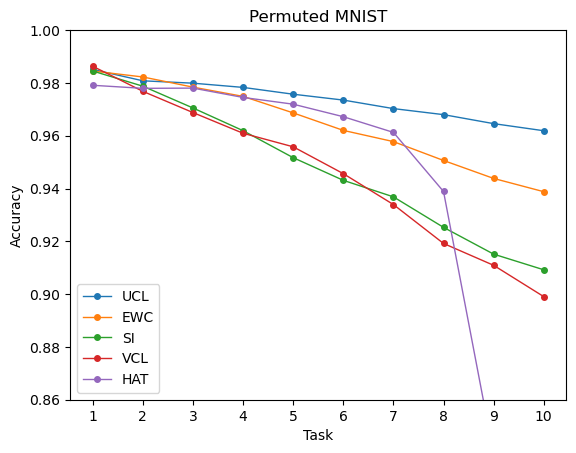

In [2]:
# Load results
acc_ucl = np.loadtxt('./result_data/pmnist_ucl_42_alpha_0.01_beta_0.03000_ratio_0.5000_lr_0.001_units_400_batch_256_epoch_100.txt')
acc_ewc = np.loadtxt('./result_data/pmnist_ewc_42_lamb_400_lr_0.001_units_400_batch_256_epoch_100.txt')
acc_si = np.loadtxt('./result_data/pmnist_si_42_c_0.03_lr_0.001_units_400_batch_256_epoch_100.txt')
acc_vcl = np.loadtxt('./result_data/pmnist_vcl_42_numsample_10_ratio_0.5000_lr_0.001_units_400_batch_256_epoch_200.txt')
acc_hat = np.loadtxt('./result_data/pmnist_hat_42_alpha_0.75_smax_400_lr_0.05_units_400_batch_256_epoch_100.txt')

tasks = np.arange(1, 11)

plt.plot(tasks, acc_ucl.sum(axis=1) / tasks, '-o', label='UCL', lw=1, markersize=4)
plt.plot(tasks, acc_ewc.sum(axis=1) / tasks, '-o', label='EWC', lw=1, markersize=4)
plt.plot(tasks, acc_si.sum(axis=1) / tasks, '-o', label='SI', lw=1, markersize=4)
plt.plot(tasks, acc_vcl.sum(axis=1) / tasks, '-o', label='VCL', lw=1, markersize=4)
plt.plot(tasks, acc_hat.sum(axis=1) / tasks, '-o', label='HAT', lw=1, markersize=4)
plt.title('Permuted MNIST')
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(tasks)
plt.ylim(0.86, 1)
plt.legend()
plt.show()

__Note__
- Add Dropout to MLP increase the performance of EWC and SI
- Add sigma_init to VCL l2 loss